In [ ]:
"""
Copyright Netherlands eScience Center
Function        : Compare atmospheric meridional energy transport (MERRA2,ERA-Interim,JRA55)
Author          : Yang Liu
Date            : 2018.05.23
Last Update     : 2018.07.06
Description     : The code aims to compare the atmospheric meridional energy transport
                  calculated from different atmospheric reanalysis datasets. In this,
                  case, this includes MERRA II from NASA, ERA-Interim from ECMWF and
                  JRA55 from JMA.
Return Value    : NetCFD4 data file
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib
variables       : Meridional Total Energy Transport           E         [Tera-Watt]
                  Meridional Internal Energy Transport        E_cpT     [Tera-Watt]
                  Meridional Latent Energy Transport          E_Lvq     [Tera-Watt]
                  Meridional Geopotential Energy Transport    E_gz      [Tera-Watt]
                  Meridional Kinetic Energy Transport         E_uv2     [Tera-Watt]
Caveat!!        : Spatial and temporal coverage
                  Temporal
                  ERA-Interim 1979 - 2016
                  MERRA2      1980 - 2016
                  JRA55       1979 - 2015
                  Spatial
                  ERA-Interim 20N - 90N
                  MERRA2      20N - 90N
                  JRA55       90S - 90N
"""

In [1]:
import seaborn as sns
import numpy as np
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas
from scipy import stats

# switch on the seaborn effect
sns.set()
sns.set_style("ticks")
sns.despine()

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
################################   Input zone  ######################################
# specify data path
#datapath_ERAI = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
#datapath_MERRA2 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
#datapath_JRA55 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
# for the computation of residual AMET ERA-Interim
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
# specify output path for the netCDF4 file
#output_path = '/home/yang/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures'
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision'
################################   Input zone  ######################################
# index of latitude for insteret
# There is a cut to JRA, too
# from 90N to 20N --> 0:125
# 20N
lat_ERAI_20 = 93
lat_MERRA2_20 = 0
lat_JRA55_20 = 124
# 30N
lat_ERAI_30 = 80
lat_MERRA2_30 = 20
lat_JRA55_30 = 106
# 40N
lat_ERAI_40 = 67
lat_MERRA2_40 = 40
lat_JRA55_40 = 88
# 50N
lat_ERAI_50 = 53
lat_MERRA2_50 = 60
lat_JRA55_50 = 70
# 60N
lat_ERAI_60 = 40
lat_MERRA2_60 = 80
lat_JRA55_60 = 53
# 70N
lat_ERAI_70 = 27
lat_MERRA2_70 = 100
lat_JRA55_70 = 35
# 80N
lat_ERAI_80 = 13
lat_MERRA2_80 = 120
lat_JRA55_80 = 17

# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [20,30,40,50,60,70,80]
lat_interest['ERAI'] = [lat_ERAI_20,lat_ERAI_30,lat_ERAI_40,lat_ERAI_50,lat_ERAI_60,lat_ERAI_70,lat_ERAI_80]
lat_interest['MERRA2'] = [lat_MERRA2_20,lat_MERRA2_30,lat_MERRA2_40,lat_MERRA2_50,lat_MERRA2_60,lat_MERRA2_70,lat_MERRA2_80]
lat_interest['JRA55'] = [lat_JRA55_20,lat_JRA55_30,lat_JRA55_40,lat_JRA55_50,lat_JRA55_60,lat_JRA55_70,lat_JRA55_80]

In [4]:
# *********************** extract variables ************************* #
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'model_daily_075_1979_2016_E_zonal_int.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc')

dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                   'surface_erai_monthly_regress_1979_2017_radiation.nc'))
# extract time series from 1979 to 2016
# from 20N - 90N
# 4D fields [year, month, lat, lon]
rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
# calculate total net energy flux at TOA/surface
net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
# from 1979 to 2016
# from 20N - 90N
# total energy transport
AMET_E_ERAI = dataset_ERAI.variables['E'][:]/1000 # from Tera Watt to Peta Watt
AMET_E_MERRA2 = dataset_MERRA2.variables['E'][:]/1000 # from Tera Watt to Peta Watt
AMET_E_JRA55 = dataset_JRA55.variables['E'][:,:,0:125]/1000 # from Tera Watt to Peta Watt
# internal energy
AMET_E_cpT_ERAI = dataset_ERAI.variables['E_cpT'][:]/1000
AMET_E_cpT_MERRA2 = dataset_MERRA2.variables['E_cpT'][:]/1000
AMET_E_cpT_JRA55 = dataset_JRA55.variables['E_cpT'][:,:,0:125]/1000
# latent heat
AMET_E_Lvq_ERAI = dataset_ERAI.variables['E_Lvq'][:]/1000
AMET_E_Lvq_MERRA2 = dataset_MERRA2.variables['E_Lvq'][:]/1000
AMET_E_Lvq_JRA55 = dataset_JRA55.variables['E_Lvq'][:,:,0:125]/1000
# geopotential
AMET_E_gz_ERAI = dataset_ERAI.variables['E_gz'][:]/1000
AMET_E_gz_MERRA2 = dataset_MERRA2.variables['E_gz'][:]/1000
AMET_E_gz_JRA55 = dataset_JRA55.variables['E_gz'][:,:,0:125]/1000
# kinetic energy
AMET_E_uv2_ERAI = dataset_ERAI.variables['E_uv2'][:]/1000
AMET_E_uv2_MERRA2 = dataset_MERRA2.variables['E_uv2'][:]/1000
AMET_E_uv2_JRA55 = dataset_JRA55.variables['E_uv2'][:,:,0:125]/1000

year_ERAI = dataset_ERAI.variables['year'][:]        # from 1979 to 2016
year_MERRA2 = dataset_MERRA2.variables['year'][:]    # from 1980 to 2016
year_JRA55 = dataset_JRA55.variables['year'][:]      # from 1979 to 2015

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][0:125]

latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]

# area weighted surface flux
net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
#size of the grid box
dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                        360) / len(longitude_fields_ERAI)
dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
for i in np.arange(len(latitude_fields_ERAI)):
    # change the unit to terawatt
    net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
    net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

In [7]:
print ('Compute AMET as the residuals of net flux at TOA & surface.')
# take the zonal mean of flux
net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
# AMET as the residual of net flux at TOA & surface
AMET_E_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
for i in np.arange(len(latitude_fields_ERAI)-1):
    AMET_E_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                             np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
print (AMET_E_res_ERAI.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)


In [12]:
# *************************** whitening ***************************** #
# remove the seasonal cycling of AMET
month_ind = np.arange(12)
# dimension of AMET[year,month]
# total energy transport
AMET_E_ERAI_seansonal_cycle = np.mean(AMET_E_ERAI,axis=0)
AMET_E_ERAI_white = np.zeros(AMET_E_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_ERAI_white[i,j,:] = AMET_E_ERAI[i,j,:] - AMET_E_ERAI_seansonal_cycle[j,:]
        
AMET_E_res_ERAI_seansonal_cycle = np.mean(AMET_E_res_ERAI,axis=0)
AMET_E_res_ERAI_white = np.zeros(AMET_E_res_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_res_ERAI_white[i,j,:] = AMET_E_res_ERAI[i,j,:] - AMET_E_res_ERAI_seansonal_cycle[j,:]

AMET_E_MERRA2_seansonal_cycle = np.mean(AMET_E_MERRA2,axis=0)
AMET_E_MERRA2_white = np.zeros(AMET_E_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_MERRA2_white[i,j,:] = AMET_E_MERRA2[i,j,:] - AMET_E_MERRA2_seansonal_cycle[j,:]

AMET_E_JRA55_seansonal_cycle = np.mean(AMET_E_JRA55,axis=0)
AMET_E_JRA55_white = np.zeros(AMET_E_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_JRA55_white[i,j,:] = AMET_E_JRA55[i,j,:] - AMET_E_JRA55_seansonal_cycle[j,:]

# internal energy
AMET_E_cpT_ERAI_seansonal_cycle = np.mean(AMET_E_cpT_ERAI,axis=0)
AMET_E_cpT_ERAI_white = np.zeros(AMET_E_cpT_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_cpT_ERAI_white[i,j,:] = AMET_E_cpT_ERAI[i,j,:] - AMET_E_cpT_ERAI_seansonal_cycle[j,:]

AMET_E_cpT_MERRA2_seansonal_cycle = np.mean(AMET_E_cpT_MERRA2,axis=0)
AMET_E_cpT_MERRA2_white = np.zeros(AMET_E_cpT_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_cpT_MERRA2_white[i,j,:] = AMET_E_cpT_MERRA2[i,j,:] - AMET_E_cpT_MERRA2_seansonal_cycle[j,:]

AMET_E_cpT_JRA55_seansonal_cycle = np.mean(AMET_E_cpT_JRA55,axis=0)
AMET_E_cpT_JRA55_white = np.zeros(AMET_E_cpT_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_cpT_JRA55_white[i,j,:] = AMET_E_cpT_JRA55[i,j,:] - AMET_E_cpT_JRA55_seansonal_cycle[j,:]

# latent heat
AMET_E_Lvq_ERAI_seansonal_cycle = np.mean(AMET_E_Lvq_ERAI,axis=0)
AMET_E_Lvq_ERAI_white = np.zeros(AMET_E_Lvq_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_Lvq_ERAI_white[i,j,:] = AMET_E_Lvq_ERAI[i,j,:] - AMET_E_Lvq_ERAI_seansonal_cycle[j,:]

AMET_E_Lvq_MERRA2_seansonal_cycle = np.mean(AMET_E_Lvq_MERRA2,axis=0)
AMET_E_Lvq_MERRA2_white = np.zeros(AMET_E_Lvq_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_Lvq_MERRA2_white[i,j,:] = AMET_E_Lvq_MERRA2[i,j,:] - AMET_E_Lvq_MERRA2_seansonal_cycle[j,:]

AMET_E_Lvq_JRA55_seansonal_cycle = np.mean(AMET_E_Lvq_JRA55,axis=0)
AMET_E_Lvq_JRA55_white = np.zeros(AMET_E_Lvq_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_Lvq_JRA55_white[i,j,:] = AMET_E_Lvq_JRA55[i,j,:] - AMET_E_Lvq_JRA55_seansonal_cycle[j,:]

# geopotential
AMET_E_gz_ERAI_seansonal_cycle = np.mean(AMET_E_gz_ERAI,axis=0)
AMET_E_gz_ERAI_white = np.zeros(AMET_E_gz_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_gz_ERAI_white[i,j,:] = AMET_E_gz_ERAI[i,j,:] - AMET_E_gz_ERAI_seansonal_cycle[j,:]

AMET_E_gz_MERRA2_seansonal_cycle = np.mean(AMET_E_gz_MERRA2,axis=0)
AMET_E_gz_MERRA2_white = np.zeros(AMET_E_gz_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_gz_MERRA2_white[i,j,:] = AMET_E_gz_MERRA2[i,j,:] - AMET_E_gz_MERRA2_seansonal_cycle[j,:]

AMET_E_gz_JRA55_seansonal_cycle = np.mean(AMET_E_gz_JRA55,axis=0)
AMET_E_gz_JRA55_white = np.zeros(AMET_E_gz_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_gz_JRA55_white[i,j,:] = AMET_E_gz_JRA55[i,j,:] - AMET_E_gz_JRA55_seansonal_cycle[j,:]

# kinetic energy
AMET_E_uv2_ERAI_seansonal_cycle = np.mean(AMET_E_uv2_ERAI,axis=0)
AMET_E_uv2_ERAI_white = np.zeros(AMET_E_uv2_ERAI.shape,dtype=float)
for i in np.arange(len(year_ERAI)):
    for j in month_ind:
        AMET_E_uv2_ERAI_white[i,j,:] = AMET_E_uv2_ERAI[i,j,:] - AMET_E_uv2_ERAI_seansonal_cycle[j,:]

AMET_E_uv2_MERRA2_seansonal_cycle = np.mean(AMET_E_uv2_MERRA2,axis=0)
AMET_E_uv2_MERRA2_white = np.zeros(AMET_E_uv2_MERRA2.shape,dtype=float)
for i in np.arange(len(year_MERRA2)):
    for j in month_ind:
        AMET_E_uv2_MERRA2_white[i,j,:] = AMET_E_uv2_MERRA2[i,j,:] - AMET_E_uv2_MERRA2_seansonal_cycle[j,:]

AMET_E_uv2_JRA55_seansonal_cycle = np.mean(AMET_E_uv2_JRA55,axis=0)
AMET_E_uv2_JRA55_white = np.zeros(AMET_E_uv2_JRA55.shape,dtype=float)
for i in np.arange(len(year_JRA55)):
    for j in month_ind:
        AMET_E_uv2_JRA55_white[i,j,:] = AMET_E_uv2_JRA55[i,j,:] - AMET_E_uv2_JRA55_seansonal_cycle[j,:]
# *********************** prepare variables ************************* #
# take the time series of original signal
# total energy transport
AMET_E_ERAI_series = AMET_E_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_MERRA2_series = AMET_E_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_JRA55_series = AMET_E_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
AMET_E_res_ERAI_series = AMET_E_res_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_fields_ERAI))
# internal energy
AMET_E_cpT_ERAI_series = AMET_E_cpT_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_cpT_MERRA2_series = AMET_E_cpT_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_cpT_JRA55_series = AMET_E_cpT_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# latent heat
AMET_E_Lvq_ERAI_series = AMET_E_Lvq_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_Lvq_MERRA2_series = AMET_E_Lvq_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_Lvq_JRA55_series = AMET_E_Lvq_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# geopotential
AMET_E_gz_ERAI_series = AMET_E_gz_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_gz_MERRA2_series = AMET_E_gz_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_gz_JRA55_series = AMET_E_gz_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# kinetic energy
AMET_E_uv2_ERAI_series = AMET_E_uv2_ERAI.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_uv2_MERRA2_series = AMET_E_uv2_MERRA2.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_uv2_JRA55_series = AMET_E_uv2_JRA55.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

# take the time series of anomalies
AMET_E_ERAI_white_series = AMET_E_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_MERRA2_white_series = AMET_E_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_JRA55_white_series = AMET_E_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
AMET_E_res_ERAI_white_series = AMET_E_res_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_fields_ERAI))
# internal energy
AMET_E_cpT_ERAI_white_series = AMET_E_cpT_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_cpT_MERRA2_white_series = AMET_E_cpT_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_cpT_JRA55_white_series = AMET_E_cpT_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# latent heat
AMET_E_Lvq_ERAI_white_series = AMET_E_Lvq_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_Lvq_MERRA2_white_series = AMET_E_Lvq_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_Lvq_JRA55_white_series = AMET_E_Lvq_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# geopotential
AMET_E_gz_ERAI_white_series = AMET_E_gz_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_gz_MERRA2_white_series = AMET_E_gz_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_gz_JRA55_white_series = AMET_E_gz_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))
# kinetic energy
AMET_E_uv2_ERAI_white_series = AMET_E_uv2_ERAI_white.reshape(len(year_ERAI)*len(month_ind),len(latitude_ERAI))
AMET_E_uv2_MERRA2_white_series = AMET_E_uv2_MERRA2_white.reshape(len(year_MERRA2)*len(month_ind),len(latitude_MERRA2))
AMET_E_uv2_JRA55_white_series = AMET_E_uv2_JRA55_white.reshape(len(year_JRA55)*len(month_ind),len(latitude_JRA55))

# ********************** Running mean/sum *************************** #

# running mean is calculated on time series
# define the running window for the running mean
#window = 12 # in month
window = 60 # in month
#window = 120 # in month
# calculate the running mean
# total energy transport
AMET_E_ERAI_running_mean = np.zeros((len(AMET_E_ERAI_series)-window+1,len(latitude_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_ERAI_series)-window+1):
    AMET_E_ERAI_running_mean[i,:] = np.mean(AMET_E_ERAI_series[i:i+window,:],0)

AMET_E_MERRA2_running_mean = np.zeros((len(AMET_E_MERRA2_series)-window+1,len(latitude_MERRA2)),dtype=float)
for i in np.arange(len(AMET_E_MERRA2_series)-window+1):
    AMET_E_MERRA2_running_mean[i,:] = np.mean(AMET_E_MERRA2_series[i:i+window,:],0)

AMET_E_JRA55_running_mean = np.zeros((len(AMET_E_JRA55_series)-window+1,len(latitude_JRA55)),dtype=float)
for i in np.arange(len(AMET_E_JRA55_series)-window+1):
    AMET_E_JRA55_running_mean[i,:] = np.mean(AMET_E_JRA55_series[i:i+window,:],0)

AMET_E_res_ERAI_running_mean = np.zeros((len(AMET_E_res_ERAI_series)-window+1,len(latitude_fields_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_res_ERAI_series)-window+1):
    AMET_E_res_ERAI_running_mean[i,:] = np.mean(AMET_E_res_ERAI_series[i:i+window,:],0)

# calculate the running mean of AMET after removing the seasonal cycling
# total energy transport
AMET_E_ERAI_white_running_mean = np.zeros((len(AMET_E_ERAI_white_series)-window+1,len(latitude_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_ERAI_white_series)-window+1):
    AMET_E_ERAI_white_running_mean[i,:] = np.mean(AMET_E_ERAI_white_series[i:i+window,:],0)

AMET_E_MERRA2_white_running_mean = np.zeros((len(AMET_E_MERRA2_white_series)-window+1,len(latitude_MERRA2)),dtype=float)
for i in np.arange(len(AMET_E_MERRA2_white_series)-window+1):
    AMET_E_MERRA2_white_running_mean[i,:] = np.mean(AMET_E_MERRA2_white_series[i:i+window,:],0)

AMET_E_JRA55_white_running_mean = np.zeros((len(AMET_E_JRA55_white_series)-window+1,len(latitude_JRA55)),dtype=float)
for i in np.arange(len(AMET_E_JRA55_white_series)-window+1):
    AMET_E_JRA55_white_running_mean[i,:] = np.mean(AMET_E_JRA55_white_series[i:i+window,:],0)

AMET_E_res_ERAI_white_running_mean = np.zeros((len(AMET_E_res_ERAI_white_series)-window+1,len(latitude_fields_ERAI)),dtype=float)
for i in np.arange(len(AMET_E_res_ERAI_white_series)-window+1):
    AMET_E_res_ERAI_white_running_mean[i,:] = np.mean(AMET_E_res_ERAI_white_series[i:i+window,:],0)

In [14]:
# ********************** standard deviation  ************************ #
# calculate the standard deviation of AMET
# ERA-Interim
AMET_E_ERAI_std = np.std(AMET_E_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_std)
# MERRA2
AMET_E_MERRA2_std = np.std(AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]])
print ('The standard deviation of AMET from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_std)
# JRA55
AMET_E_JRA55_std = np.std(AMET_E_JRA55_series[:,lat_interest['JRA55'][4]])
print ('The standard deviation of AMET from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_std)
# ERA-Interim res
AMET_E_res_ERAI_std = np.std(AMET_E_res_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_res_ERAI_std)

# calculate the standard deviation of AMET anomaly
# ERA-Interim
AMET_E_ERAI_white_running_mean_std = np.std(AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_white_running_mean_std)
# MERRA2
AMET_E_MERRA2_white_running_mean_std = np.std(AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]])
print ('The standard deviation of AMET anomaly from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_white_running_mean_std)
# JRA55
AMET_E_JRA55_white_running_mean_std = np.std(AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]])
print ('The standard deviation of AMET anomaly from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_white_running_mean_std)
# ERA-Interim
AMET_E_res_ERAI_white_running_mean_std = np.std(AMET_E_res_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_res_ERAI_white_running_mean_std)
# *************************** mean value  *************************** #
# calculate the mean of AMET
# ERA-Interim
AMET_E_ERAI_mean = np.mean(AMET_E_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The mean of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_mean)
# MERRA2
AMET_E_MERRA2_mean = np.mean(AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]])
print ('The mean of AMET from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_mean)
# JRA55
AMET_E_JRA55_mean = np.mean(AMET_E_JRA55_series[:,lat_interest['JRA55'][4]])
print ('The mean of AMET from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_mean)
# ERA-Interim
AMET_E_res_ERAI_mean = np.mean(AMET_E_res_ERAI_series[:,lat_interest['ERAI'][4]])
print ('The mean of AMET from ERA-Interim is (in peta Watt):')
print (AMET_E_res_ERAI_mean)

# calculate the standard deviation of AMET anomaly
# ERA-Interim
AMET_E_ERAI_white_mean_running_mean = np.mean(AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The mean of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_ERAI_white_mean_running_mean)
# MERRA2
AMET_E_MERRA2_white_mean_running_mean = np.mean(AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]])
print ('The mean of AMET anomaly from MERRA2 is (in peta Watt):')
print (AMET_E_MERRA2_white_mean_running_mean)
# JRA55
AMET_E_JRA55_white_mean_running_mean = np.mean(AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]])
print ('The mean of AMET anomaly from JRA55 is (in peta Watt):')
print (AMET_E_JRA55_white_mean_running_mean)
# ERA-Interim
AMET_E_res_ERAI_white_mean_running_mean = np.mean(AMET_E_res_ERAI_white_running_mean[:,lat_interest['ERAI'][4]])
print ('The mean of AMET anomaly from ERA-Interim is (in peta Watt):')
print (AMET_E_res_ERAI_white_mean_running_mean)

The standard deviation of AMET from ERA-Interim is (in peta Watt):
0.8813682239623769
The standard deviation of AMET from MERRA2 is (in peta Watt):
0.6708961063130783
The standard deviation of AMET from JRA55 is (in peta Watt):
1.2136118955827604
The standard deviation of AMET from ERA-Interim is (in peta Watt):
1.3294528384928777
The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):
0.06801317492631591
The standard deviation of AMET anomaly from MERRA2 is (in peta Watt):
0.12159324028174025
The standard deviation of AMET anomaly from JRA55 is (in peta Watt):
0.04269698402282107
The standard deviation of AMET anomaly from ERA-Interim is (in peta Watt):
0.05109024224636256
The mean of AMET from ERA-Interim is (in peta Watt):
2.5214168446318386
The mean of AMET from MERRA2 is (in peta Watt):
2.5806875596456087
The mean of AMET from JRA55 is (in peta Watt):
2.5631246127481893
The mean of AMET from ERA-Interim is (in peta Watt):
3.0599991087937206
The mean of AMET anom

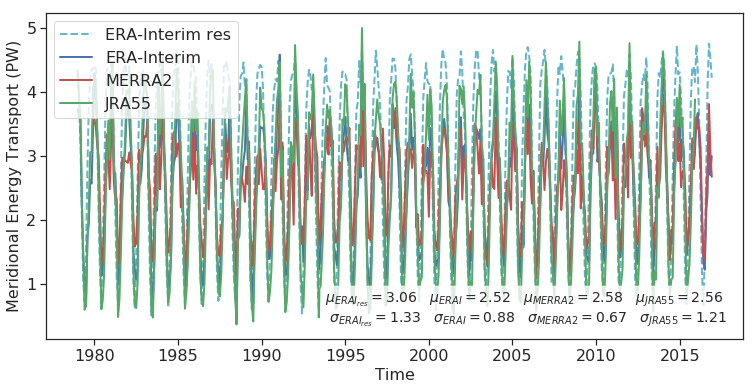

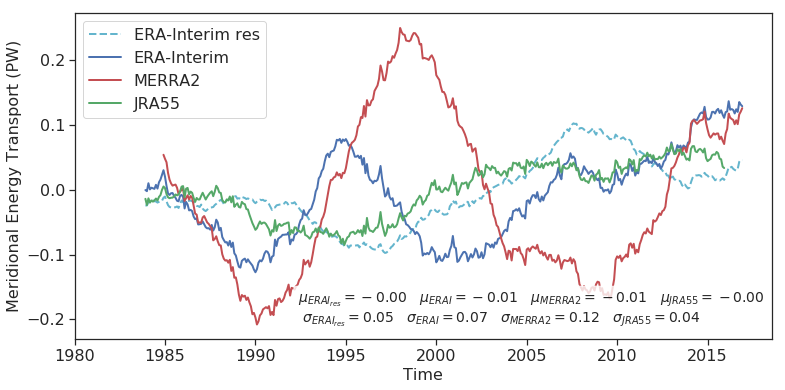

In [18]:
# *************************** time series *************************** #
index_1980_2016 = np.arange(13,457,1)
index_1979_2016 = np.arange(1,457,1)
index_1979_2015 = np.arange(1,445,1)
index_1980_2015 = np.arange(1,433,1)
index_year = np.arange(1980,year_ERAI[-1]+1,5)

# plot the AMET with running mean
# total energy transport
text_content = '$\mu_{ERAI_{res}}=%.2f$   $\mu_{ERAI}=%.2f$   $\mu_{MERRA2}=%.2f$   $\mu_{JRA55}=%.2f$ \n $\sigma_{ERAI_{res}}=%.2f$   $\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                % (AMET_E_res_ERAI_mean, AMET_E_ERAI_mean, AMET_E_MERRA2_mean, AMET_E_JRA55_mean, AMET_E_res_ERAI_std, AMET_E_ERAI_std, AMET_E_MERRA2_std, AMET_E_JRA55_std)

fig3 = plt.figure()
plt.plot(index_1979_2016,AMET_E_res_ERAI_series[:,lat_interest['ERAI'][4]],'c--',linewidth=2.0,label='ERA-Interim res')
plt.plot(index_1979_2016,AMET_E_ERAI_series[:,lat_interest['ERAI'][4]],'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_1980_2016,AMET_E_MERRA2_series[:,lat_interest['MERRA2'][4]],'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_1979_2015,AMET_E_JRA55_series[:,lat_interest['JRA55'][4]],'g-',linewidth=2.0,label='JRA55')
#plt.title('Running Mean of AMET at 60N with a window of 60 months' % (lat_interest_list[i],window))
plt.legend()
fig3.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), year_ERAI,fontsize=16)
#plt.xticks(rotation=60)
plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
# set up the text box
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.4,0.15,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig3.savefig(output_path + os.sep + 'Comp_AMET_E_60N_running_mean_window_60m_comp.jpg', dpi = 400)
plt.close(fig3)


text_content = '$\mu_{ERAI_{res}}=%.2f$   $\mu_{ERAI}=%.2f$   $\mu_{MERRA2}=%.2f$   $\mu_{JRA55}=%.2f$ \n $\sigma_{ERAI_{res}}=%.2f$   $\sigma_{ERAI}=%.2f$   $\sigma_{MERRA2}=%.2f$   $\sigma_{JRA55}=%.2f$' \
                % (AMET_E_res_ERAI_white_mean_running_mean, AMET_E_ERAI_white_mean_running_mean, AMET_E_MERRA2_white_mean_running_mean, AMET_E_JRA55_white_mean_running_mean, AMET_E_res_ERAI_white_running_mean_std, AMET_E_ERAI_white_running_mean_std, AMET_E_MERRA2_white_running_mean_std, AMET_E_JRA55_white_running_mean_std)

# plot the AMET after removing the seasonal cycling with running mean
fig8= plt.figure()
plt.plot(index_1979_2016[window-1:],AMET_E_res_ERAI_white_running_mean[:,lat_interest['ERAI'][4]],'c--',linewidth=2.0,label='ERA-Interim res')
plt.plot(index_1979_2016[window-1:],AMET_E_ERAI_white_running_mean[:,lat_interest['ERAI'][4]],'b-',linewidth=2.0,label='ERA-Interim')
plt.plot(index_1980_2016[window-1:],AMET_E_MERRA2_white_running_mean[:,lat_interest['MERRA2'][4]],'r-',linewidth=2.0,label='MERRA2')
plt.plot(index_1979_2015[window-1:],AMET_E_JRA55_white_running_mean[:,lat_interest['JRA55'][4]],'g-',linewidth=2.0,label='JRA55')
#plt.title('Running Mean of AMET Anomalies at %dN with a window of %d months' % (lat_interest_list[i],window))
fig8.set_size_inches(12.5, 6)
plt.xlabel("Time",fontsize=16)
#plt.xticks(np.linspace(0, 456, 39), year_ERAI)
plt.xticks(np.arange(13,len(year_ERAI)*12+1,60), index_year,fontsize=16)
#plt.xticks(rotation=60)
plt.ylabel("Meridional Energy Transport (PW)",fontsize=16)
plt.yticks(fontsize=16)
plt.legend(frameon=True, loc=2, prop={'size': 16})
props = dict(boxstyle='round',facecolor='white', alpha=0.8)
ax = plt.gca()
ax.text(0.32,0.15,text_content,transform=ax.transAxes,fontsize=14,verticalalignment='top',bbox=props)
plt.show()
fig8.savefig(output_path + os.sep + 'Comp_AMET_E_anomaly_60N_running_mean_window_60m_comp.jpg', dpi = 400)
plt.close(fig8)